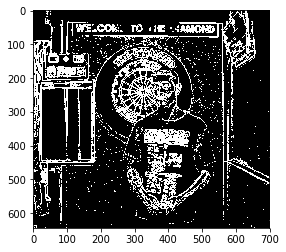

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import time

i=7

# location = "../images/dart.bmp"
location = str("../images/dart") + str(i) + str(".jpg")
imgcol = cv2.imread(location)
img = 2*np.array(cv2.cvtColor(imgcol, cv2.COLOR_BGR2GRAY))

#implement own sobel operator***********************************
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

(M,N) = sobelx.shape
grad = np.zeros((M,N))
direc = np.zeros((M,N))
thresh = np.sum(img)/(N*M)

for m in range (0,M): #m = y
    for n in range  (0,N): # n = x
        grad[m,n] = math.sqrt(sobelx[m,n]**2 + sobely[m,n]**2)
        if sobelx[m,n] == 0: # to prevent division by zero in direc
            sobelx[m,n]= 1*10**(-5)
        direc[m,n] = np.arctan(sobely[m,n]/sobelx[m,n])
        if grad[m,n]>thresh:
            grad[m,n] = 255
        else:
            grad[m,n] = 0
# grad = cv2.Canny(img, thresh*0.5, thresh*2, 3 )
            
saveloc1 = (str("edgedetected/dartedge" + str(i) + str(".jpg")))
cv2.imwrite(saveloc1,grad)
plt.imshow(grad, cmap='gray')

In [ ]:
#Hough Circle

#assuming the full board has to be in the image and the board isn't distorted. 
maxrad = 100 #int(max(M,N)) #rad of largest circle
nc =  maxrad #numcir 

stime = time.time()
rad = np.zeros(nc)
for a in range (10,nc): # not zero to stop detection of tiny dots
    rad[a] = (a+1)*maxrad/nc

Hxyr = np.zeros ((M,N,nc))
total= M*N


for m in range (0,M): #y
    for n in range (0,N): #x
        if grad[m,n] == 255:
            for r in rad:
                # optimisation of the for loop to only cater for the top left quarter of a circle to its center
                y0 = int(np.round(m + r*math.sin(direc[m,n])))
#                 y1 = int(np.round(m - r*math.sin(direc[m,n])))                    
                x0 = int(np.round(n + r*math.cos(direc[m,n])))
#                 x1 = int(np.round(n - r*math.cos(direc[m,n])))
                
                y1 = int(np.round(m + r*math.sin(direc[m,n]+math.pi/180)))
                x1 = int(np.round(n + r*math.cos(direc[m,n]+math.pi/180))) 
                y2 = int(np.round(m + r*math.sin(direc[m,n]-math.pi/180)))
                x2 = int(np.round(n + r*math.cos(direc[m,n]-math.pi/180)))
                
                #removing 2 if statements to speed up the loop
                dx = 2*abs(x2-x1)
                dy = 2*abs(y2-y1)
                
                radindex = int(nc*r/maxrad -1)
                if dy<=y0<M-dy and dx<=x0<N-dx:
                    Hxyr[y0,x0,radindex] += 1
#                 if 0<=y1<M and 0<=x1<N:
                    Hxyr[y1,x1,radindex] += 1
#                 if 0<=y2<M and 0<=x2<N:
                    Hxyr[y2,x2,radindex] += 1    
                else: 
                    break #break to prevent unecessary calculation wiht larger r values
                
                #case where all the points are in the grid
#                 if 0<=y0<M and 0<=x0<N and 0<=y1<M and 0<=x1<N:
#                     Hxyr[y0,x0,radindex] += 1
#                     Hxyr[y1,x0,radindex] += 1
#                     Hxyr[y0,x1,radindex] += 1
#                     Hxyr[y1,x1,radindex] += 1
#                 else:
#                     # other cases
#                     if 0<=y0<M and 0<=x0<N:
#                         Hxyr[y0,x0,radindex] += 1
#                     if 0<=y1<M and 0<=x1<N:
#                         Hxyr[y1,x1,radindex] += 1
#                     if 0<=y0<M and 0<=x1<N:
#                         Hxyr[y0,x1,radindex] += 1
#                     if 0<=y1<M and 0<=x0<N:
#                         Hxyr[y1,x0,radindex] += 1
etime = time.time()
print("runtime: Hough space " + str(etime-stime))               

#Drawing most likely circles back onto image

imgcol = cv2.imread(location)

def imshow(image):
    #OpenCV stores images in BGR so we have to convert to RGB to display it using matplotlib
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imagergb)


(a,b,c) = Hxyr.shape #to calculate the no of elements
nth = 20#number of green circles drawn

argord = Hxyr.argsort(axis=None) #lists the indeces in accending order of value (array is flattened) 
(y,x,r)=np.unravel_index(argord[a*b*c-nth], (a,b,c)) #unravels the flattened value back into a tuple for the nth highest 
thresh = Hxyr[y,x,r]

stime = time.time()
for m in range (0,M): #y
    for n in range (0,N):#x
        for radindex in range (0,nc):
            if Hxyr[m,n,radindex]>thresh:
                r = (radindex+1)*maxrad/nc
                cv2.circle(imgcol, (n,m), int(r), (0,255,0), 3, cv2.LINE_AA)
etime = time.time()
print("runtime, circ drawing: " + str(etime-stime))  
saveloc2 = (str("circledetected/dart2circ" + str(i) + str(".jpg")))
cv2.imwrite(saveloc2,imgcol)
imshow(imgcol)

In [ ]:
#Plotting Hough Space
(a,b,c) = Hxyr.shape #to calculate the no of elements
Hspace = np.zeros((a,b))
stime = time.time()
for y in range (0,a):
    for x in range (0,b):
        sum = 0
        for z in range (0,c):
            sum += Hxyr[y,x,z]
        Hspace[y,x] = sum
#normalising the values
norm = np.amax(Hspace)
Hspace = Hspace*255/norm
etime = time.time()
print ("runtime Hough space: " + str(etime-stime))


In [ ]:
def imshow(image):
    #OpenCV stores images in BGR so we have to convert to RGB to display it using matplotlib
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imagergb)

imgcol = cv2.imread(location)
(a,b) = Hspace.shape #for later to calculate the highest index of the flattened array
argord = Hspace.argsort(axis=None) #lists the indices in accending order of value (array is flattened) 
(y,x)=np.unravel_index(argord[a*b-1], (a,b)) #unravels the flattened value back into a tuple for the nth highest 

a = Hxyr[y,x].shape
argord = Hxyr[y,x].argsort(axis=None)
rindex = argord[a[0]-1]
r = Hxyr[y,x,rindex]
# r = np.amax(Hxyr[y,x])
print (Hspace[y,x])
cv2.circle(imgcol, (x,y), int(r), (0,255,0), 1, cv2.LINE_AA)
saveloc2 = (str("circledetected/dart2circ" + str(i) + str(".jpg")))
cv2.imwrite(saveloc2,imgcol)
imshow(imgcol)

In [ ]:
saveloc3 = (str("circledetected/dart2circ_HS" + str(i) + str(".jpg")))
cv2.imwrite(saveloc3,Hspace)
plt.imshow(Hspace, cmap='gray')

#Hough Lines

nl=200
theta = np.zeros(nl)

for a in range (0,nl):
    theta[a] = a*2*math.pi/nl

#Hough space
maxd = 2*math.sqrt(M**2 + N**2)
Hroth = np.zeros((int(maxd), nl))

stime = time.time()
for m in range (0,M): #y
    for n in range (0,N): #x
        if grad[m,n]==255:
            for t in theta:
#                 if direc[m,n]-2*math.pi/nl<=t<=direc[m,n]+2*math.pi/nl: 
                    ro = int(np.round(n*math.cos(t) + m*math.cos(t)))
                    tindex = int(np.round(t*nl/(2*math.pi)))
                    Hroth[ro,tindex] += 1
etime = time.time()
print("runtime: " + str(etime-stime))             

np.amax(Hroth)


#Drawing the most likely lines on the image

imgcol = cv2.imread(location)
(M,N) = img.shape    
(a,b) = Hroth.shape #for later to calculate the highest index of the flattened array
nth =  100#number of green lines drawn
argord = Hroth.argsort(axis=None) #lists the indices in accending order of value (array is flattened) 
(roindex,tindex)=np.unravel_index(argord[a*b-nth], (a,b)) #unravels the flattened value back into a tuple for the nth highest 
thresh = Hroth[roindex,tindex]

stime = time.time()
for ro in range (0,a):
    for tindex in range (0,b):
        if Hroth[ro,tindex]>thresh:
            
            t = tindex*2*math.pi/nl
            if math.cos(t)==0:
                y1 = int(np.round(ro/math.sin(t)))
                x1 = int(0)
                y2 = y1
                x2 = int(N-1)
                cv2.line(imgcol, (x1,y1),(x2,y2), (255,0,0), 5, cv2.LINE_AA)
                
            elif math.sin(t)==0:
                x1 = int(np.round(ro/math.cos(t)))
                y1 = 0
                x2 = x1
                y2 = M-1
                cv2.line(imgcol, (x1,y1),(x2,y2), (0,0,255), 5, cv2.LINE_AA)
            else:    
                x = int(np.round(ro/math.cos(t)))
                y = int(np.round(ro/math.sin(t)))
                m = math.tan(t) #gradient of line y = mx + c
                c = y - m*x
                x1 = int(0)
                y1 = int(c)
                x2 = N-1
                y2 = int(np.round(m*x2 + c))
                if y1<N and y2<N:
                    cv2.line(imgcol, (x1,y1),(x2,y2), (255,0,0), 1, cv2.LINE_AA)
                elif y1<N:
                    y2 = int(M-1)
                    x2 = int(np.round((y2-c)/m)) 
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,0,255), 1, cv2.LINE_AA)
                elif y2<N:
                    y1 = M-1
                    x1 = int(np.round((y1-c)/m))
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,255,0), 3, cv2.LINE_AA)
                else:
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,255,0), 3, cv2.LINE_AA)
            
etime = time.time()

print("runtime: " + str(etime-stime))               
imshow(imgcol)